In [2]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [19]:
data_path = '/home/anuki/ICIP2022-ParEggChallenge/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
ann_file = '/home/anuki/ICIP2022-ParEggChallenge/5-fold/fold-2/val.json'
coco_gt = COCO(ann_file)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [33]:
folder = 'test-sliced'
pred_file = f'/home/anuki/ICIP2022-ParEggChallenge/predict/{folder}/result.json'
coco_dt = coco_gt.loadRes(pred_file)

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!


In [21]:
imgIds = sorted(coco_gt.getImgIds())
cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')
cocoEval.params.imgIds  = imgIds
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.05s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.977
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.914
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.875
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.920
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.924
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1

In [10]:
a = [key for key in cocoEval.ious if len(cocoEval.ious[key])>0 and len(cocoEval.ious[key][0])>1]
print(a)

[(4, 0), (38, 0), (54, 0), (71, 0), (489, 6), (567, 4), (830, 8), (831, 8), (881, 8), (902, 9), (1114, 0), (1172, 0), (1178, 0), (1209, 1), (1259, 1), (1280, 1), (1365, 2), (1544, 6), (1633, 4), (1681, 4), (1906, 8), (1925, 8), (1931, 8), (1966, 8), (1972, 8), (1991, 8), (2011, 9), (2088, 9)]


In [91]:
np.max(cocoEval.ious[9283, 9], axis = 0)

array([0.94455558, 0.        ])

In [89]:
coco_gt.imgToAnns[9283]

[{'id': 9300,
  'image_id': 9283,
  'category_id': 9,
  'bbox': [1350.0, 2057.0, 191.00000000000003, 188.0],
  'area': 35908.00000000001,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0},
 {'id': 9301,
  'image_id': 9283,
  'category_id': 9,
  'bbox': [1518.9999999999998, 2288.0, 178.0, 191.0],
  'area': 33998.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0}]

In [90]:
coco_dt.imgToAnns[9283]

[{'image_id': 9283,
  'bbox': [1342.431396484375,
   2056.570114135742,
   200.29443359375,
   189.7993927001953],
  'score': 0.9705298542976379,
  'category_id': 9,
  'category_name': 'Taenia spp. egg',
  'segmentation': [],
  'iscrowd': 0,
  'area': 38015.76185732335,
  'id': 2456}]

In [46]:
coco_gt.imgs[1208]

{'id': 1208,
 'file_name': 'Ascaris lumbricoides_0208.jpg',
 'height': 4032,
 'width': 2117,
 'license': 1,
 'coco_url': None}

In [104]:
import json

def adjust_bbox(ann_path):
    file = open(ann_path)
    annotations = json.load(file)
    for ann in annotations['annotations']:
        for i in range(4):
            if ann['bbox'][i] < 0:
                ann['bbox'][i] = 0.0
    temp_file = 'mod-val.json'
    with open(temp_file, 'w') as file:
        json.dump(annotations, file)
    return temp_file
    

In [28]:
import numpy as np
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

def evaluate(data_path, ann_path, res_path):
    coco_gt = COCO(ann_path)
    coco_dt = coco_gt.loadRes(res_path)

    imgIds = sorted(coco_gt.getImgIds())
    cocoEval = COCOeval(coco_gt, coco_dt, 'bbox')
    cocoEval.params.imgIds  = imgIds
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()
    
    class_ious = [0] * 11
    class_metrics = [dict(tp=0, fp=0, fn=0) for i in range(11)]
    class_avg_ious = []
    class_f1 = []
    for i in range(11):
        ious = []
        for key, value in cocoEval.ious.items(): 
            if key[1] == i and len(value) > 0:
                ious.extend(np.max(value, axis=0))
                matches_gt = np.max(value, axis=0)
                matches_dt = np.max(value, axis=1)
                tp = np.sum(matches_gt >= 0.5)
                fp = len(matches_dt) - tp
                fn = len(matches_gt) - tp
                class_metrics[i]['tp'] += tp
                class_metrics[i]['fp'] += fp
                class_metrics[i]['fn'] += fn


        class_ious[i] = ious
        class_avg_ious.append(np.mean(ious))

        precision = class_metrics[i]['tp'] / (class_metrics[i]['tp'] + class_metrics[i]['fp'])
        recall = class_metrics[i]['tp'] / (class_metrics[i]['tp'] + class_metrics[i]['fn'])
        fnr = 100* class_metrics[i]['fn'] / (class_metrics[i]['tp'] + class_metrics[i]['fn'])
        class_metrics[i]['precision'] = precision
        class_metrics[i]['recall'] = recall
        class_metrics[i]['fnr'] = fnr 

        f1 = 2 * precision * recall / (precision + recall)
        class_f1.append(f1)

        print(f"{coco_gt.cats[i]['name']}:\tAverage IoU = {class_avg_ious[-1]}\t F1 = {f1}\tPrecision = {precision}\t Recall = {recall}\t FNR = {fnr}")

    print("mIoU =", np.mean(class_avg_ious))
    print("mF1 =", np.mean(class_f1))


    return cocoEval, class_ious, class_avg_ious, class_metrics, class_f1, coco_gt, coco_dt

In [29]:
data_path = '/home/anuki/ICIP2022-ParEggChallenge/test/data'
ann_path = '/home/anuki/ICIP2022-ParEggChallenge/test/test_labels.json'
folder = 'actual-test-sliced2'
res_path = f'/home/anuki/ICIP2022-ParEggChallenge/predict/{folder}/result.json'

cocoEval, class_ious, class_avg_ious, class_metrics, class_f1, coco_gt, coco_dt = evaluate(data_path, ann_path, res_path)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.02s).
Accumulating evaluation results...
DONE (t=0.27s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.936
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.918
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.841
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.885
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.896
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [7]:
cocoEval.eval['precision'].shape

(10, 101, 11, 4, 3)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   1.,   2.,   1.,   2.,   0.,   2.,   2.,   3.,  15.,  17.,
         31.,  62.,  91., 187., 419., 810., 558.]),
 array([0.        , 0.02493911, 0.04987822, 0.07481732, 0.09975643,
        0.12469554, 0.14963465, 0.17457375, 0.19951286, 0.22445197,
        0.24939108, 0.27433019, 0.29926929, 0.3242084 , 0.34914751,
        0.37408662, 0.39902572, 0.42396483, 0.44890394, 0.47384305,
        0.49878216, 0.52372126, 0.54866037, 0.57359948, 0.59853859,
        0.6234777 , 0.6484168 , 0.67335591, 0.69829502, 0.72323413,
        0.74817323, 0.77311234, 0.79805145, 0.82299056, 0.84792967,
        0.87286877, 0.89780788, 0.92274699, 0.9476861 , 0.9726252 ,
        0.99756431]),
 <BarContainer object of 40 artists>)

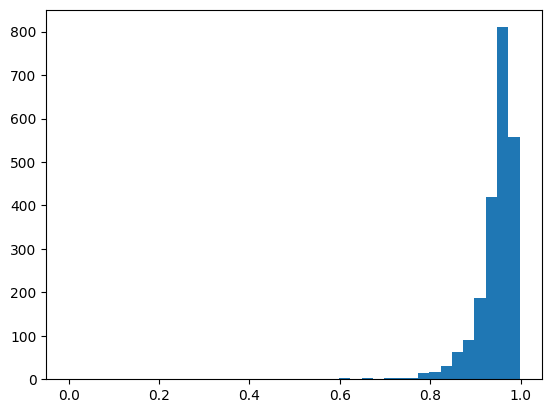

In [109]:
import matplotlib.pyplot as plt
total = sum(class_ious, start=[])
plt.hist(total, bins=40)

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize(img_id, coco_gt, coco_dt):

    image = plt.imread(data_path + '/' + coco_gt.imgs[img_id]['file_name'])
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.grid('off')

    for pred in coco_gt.imgToAnns[img_id]:
        x, y, w, h = pred['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='g', facecolor='none')
        ax.add_patch(rect)

    for pred in coco_dt.imgToAnns[img_id]:
        x, y, w, h = pred['bbox']
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

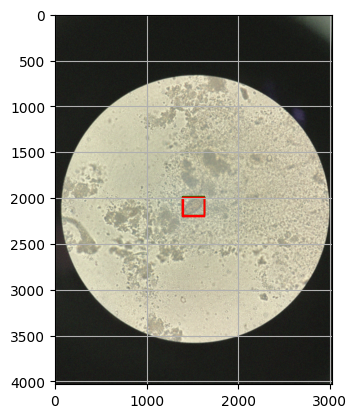

In [36]:
visualize(2166, coco_gt, coco_dt)

In [34]:
for image in coco_gt.getImgIds():
    if coco_gt.imgs[image]['file_name'] == '0058.jpg':
        print(image)
        break

2166


In [38]:
coco_dt.imgToAnns[2166]

[{'image_id': 2166,
  'bbox': [1398.151123046875,
   1987.218994140625,
   224.009521484375,
   199.392822265625],
  'score': 0.5032287836074829,
  'category_id': 7,
  'category_name': 'Opisthorchis viverrine',
  'segmentation': [],
  'iscrowd': 0,
  'area': 44665.89070314169,
  'id': 2976},
 {'image_id': 2166,
  'bbox': [1389.7742919921875,
   1987.003662109375,
   237.72705078125,
   207.09161376953125],
  'score': 0.6762388944625854,
  'category_id': 8,
  'category_name': 'Paragonimus spp',
  'segmentation': [],
  'iscrowd': 0,
  'area': 49231.27858296037,
  'id': 2977},
 {'image_id': 2166,
  'bbox': [1389.9600524902344,
   1987.003662109375,
   233.80032348632812,
   207.09161376953125],
  'score': 0.5730828642845154,
  'category_id': 10,
  'category_name': 'Trichuris trichiura',
  'segmentation': [],
  'iscrowd': 0,
  'area': 48418.08629062213,
  'id': 2978}]

In [62]:
coco_dt.imgToAnns[1209]

[{'image_id': 1209,
  'bbox': [1330.1502685546875,
   706.25732421875,
   354.6839599609375,
   329.76983642578125],
  'score': 0.9431892037391663,
  'category_id': 0,
  'category_name': 'Ascaris lumbricoides',
  'segmentation': [],
  'iscrowd': 0,
  'area': 116964.0714591667,
  'id': 307},
 {'image_id': 1209,
  'bbox': [1538.67236328125, 0.0, 300.93798828125, 173.47964477539062],
  'score': 0.8812294006347656,
  'category_id': 0,
  'category_name': 'Ascaris lumbricoides',
  'segmentation': [],
  'iscrowd': 0,
  'area': 52206.61530645192,
  'id': 308},
 {'image_id': 1209,
  'bbox': [1213.9686279296875,
   170.2615966796875,
   66.0313720703125,
   133.9027099609375],
  'score': 0.42282184958457947,
  'category_id': 1,
  'category_name': 'Capillaria philippinensis',
  'segmentation': [],
  'iscrowd': 0,
  'area': 8841.779662653804,
  'id': 309},
 {'image_id': 1209,
  'bbox': [1757.1528930664062,
   1862.7424011230469,
   1021.1996459960938,
   517.7306213378906],
  'score': 0.4152384102

In [66]:
coco_gt.imgToAnns[1209]

[{'id': 1213,
  'image_id': 1209,
  'category_id': 0,
  'bbox': [1546.0, -104.0, 295.0, 269.0],
  'area': 79355.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0},
 {'id': 1214,
  'image_id': 1209,
  'category_id': 0,
  'bbox': [1341.0, 708.0, 333.0, 329.0],
  'area': 109557.0,
  'iscrowd': 0,
  'ignore': 0,
  '_ignore': 0}]

In [100]:
adjust_bbox(ann_path)

loading annotations into memory...


TypeError: expected str, bytes or os.PathLike object, not dict

In [8]:
dict(tp=1)

{'tp': 1}